In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.random import set_seed

from pandas_datareader.data import DataReader

import warnings
warnings.simplefilter("ignore")

set_seed(455)
np.random.seed(455)

In [2]:
end = datetime.now()
start = datetime(2015, end.month, end.day)
df = yf.download("AAPL", start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-15,31.602501,31.782499,31.502501,31.695000,28.599016,115881600
2015-04-16,31.570000,31.775000,31.527500,31.542500,28.461412,113476000
2015-04-17,31.387501,31.535000,31.115000,31.187500,28.141087,207828000
2015-04-20,31.392500,32.029999,31.292500,31.900000,28.783985,188217200
2015-04-21,32.025002,32.049999,31.667500,31.727501,28.628345,129740400
...,...,...,...,...,...,...
2023-04-10,161.419998,162.029999,160.080002,162.029999,162.029999,47716900
2023-04-11,162.350006,162.360001,160.509995,160.800003,160.800003,47644200
2023-04-12,161.220001,162.059998,159.779999,160.100006,160.100006,50133100


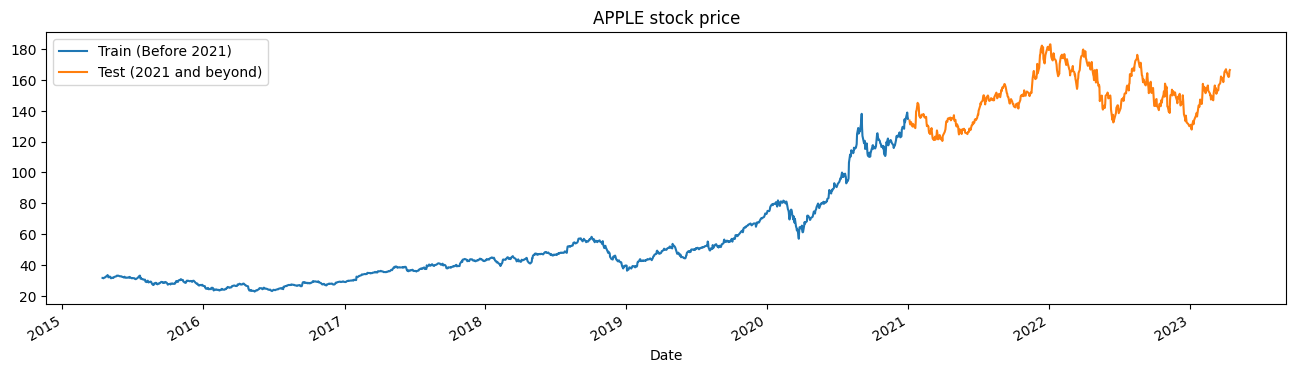

In [4]:
tstart = 2015
tend = 2020

def train_test_plot(df, tstart, tend):
    df.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    df.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()

train_test_plot(df,tstart,tend)

In [5]:
def train_test_split(df, tstart, tend):
    train = df.loc[f"{tstart}":f"{tend}", "High"]
    test = df.loc[f"{tend+1}":, "High"]
    return train, test

def train_test_split_values(df, tstart, tend):
    train, test =  train_test_split(df, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(df, tstart, tend)

In [6]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [7]:
def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, window_size)

In [8]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [9]:
model_gru = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=125, activation="tanh"), input_shape=(window_size, features)),
    tf.keras.layers.Dense(units=1)
])

model_gru.compile(optimizer='adam', loss='mse', metrics=('mae', 'mse'))

model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 250)              96000     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 251       
                                                                 
Total params: 96,251
Trainable params: 96,251
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_gru.fit(X_train, y_train, epochs=32, batch_size=32)

Epoch 1/20
44/44 [==============================] - 1s 25ms/step - loss: 1.4238e-04 - mae: 0.0073 - mse: 1.4238e-04
Epoch 2/20
44/44 [==============================] - 1s 24ms/step - loss: 1.8258e-04 - mae: 0.0087 - mse: 1.8258e-04
Epoch 3/20
44/44 [==============================] - 1s 25ms/step - loss: 1.2689e-04 - mae: 0.0070 - mse: 1.2689e-04
Epoch 4/20
44/44 [==============================] - 1s 25ms/step - loss: 1.3515e-04 - mae: 0.0071 - mse: 1.3515e-04
Epoch 5/20
44/44 [==============================] - 1s 27ms/step - loss: 1.4098e-04 - mae: 0.0078 - mse: 1.4098e-04
Epoch 6/20
44/44 [==============================] - 1s 26ms/step - loss: 1.3116e-04 - mae: 0.0069 - mse: 1.3116e-04
Epoch 7/20
44/44 [==============================] - 1s 25ms/step - loss: 1.3648e-04 - mae: 0.0069 - mse: 1.3648e-04
Epoch 8/20
44/44 [==============================] - 1s 26ms/step - loss: 1.2167e-04 - mae: 0.0067 - mse: 1.2167e-04
Epoch 9/20
44/44 [==============================] - 1s 26ms/step - loss:

In [17]:
df_total = df.loc[:,"High"]
inputs = df_total[len(df_total) - len(test_set) - window_size :].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [18]:
X_test, y_test = split_sequence(inputs, window_size)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
predicted_stock_price = model_gru.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)

18/18 [==============================] - 0s 7ms/step


In [19]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rse = mean_squared_error(test, predicted)
    rmse = np.sqrt(rse)
    print("The root mean squared error is {:.2f}.".format(rmse))
    
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("The mean absolute error is {:.2f}.".format(mae))

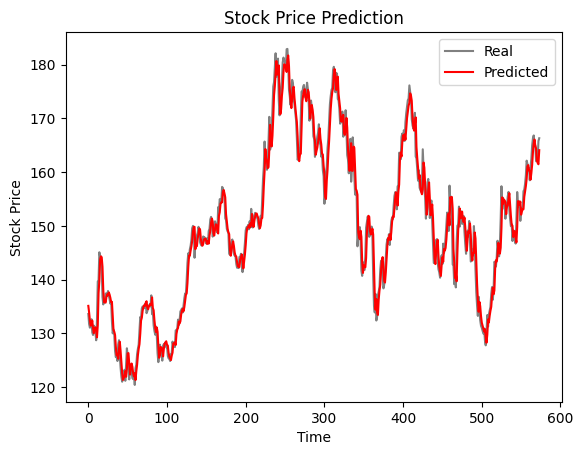

In [20]:
plot_predictions(y_test,predicted_stock_price)

In [21]:
rse = return_rmse(y_test,predicted_stock_price)
mae = return_mae(y_test,predicted_stock_price)

The root mean squared error is 2.60.
The mean absolute error is 2.02.
